### Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import torch

#### Load the dataset

In [2]:
# Load the dataset
df = pd.read_csv('movie.csv')

## EDA (Exploratory Data Analysis)

Display the first few rows of the dataset

In [3]:
print(df.head())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


Basic statistics of the dataset

In [4]:
print(df.describe())

              label
count  40000.000000
mean       0.499525
std        0.500006
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


Check for missing values

In [5]:
 
print(df.isnull().sum())

text     0
label    0
dtype: int64


Distribution of the labels (sentiments)

In [6]:
print(df['label'].value_counts())

label
0    20019
1    19981
Name: count, dtype: int64


Plot the graph of lenth of postive and negative reviews

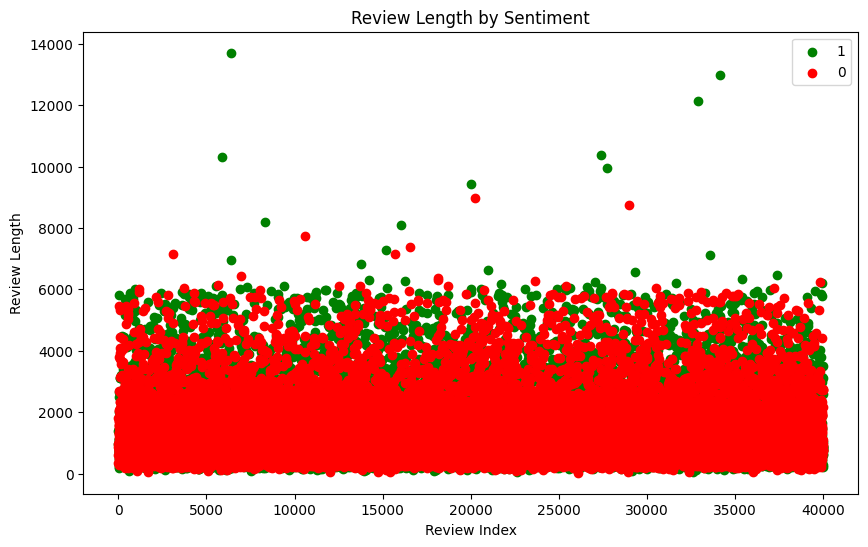

In [7]:
df['review_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))

# Plot positive reviews in green
plt.scatter(df[df['label'] == 1].index, 
            df[df['label'] == 1]['review_length'], 
            color='green', label= 1)

# Plot negative reviews in red
plt.scatter(df[df['label'] == 0].index, 
            df[df['label'] == 0]['review_length'], 
            color='red', label= 0)

plt.xlabel('Review Index')
plt.ylabel('Review Length')
plt.title('Review Length by Sentiment')
plt.legend()
plt.show()


Data cleaning (remove duplicate reviews)

In [8]:
df.dropna(subset=["text"], inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)

Distribution of the labels (sentiments)<br>
Plot the graph of lenth of postive and negative reviews

label
1    19908
0    19815
Name: count, dtype: int64


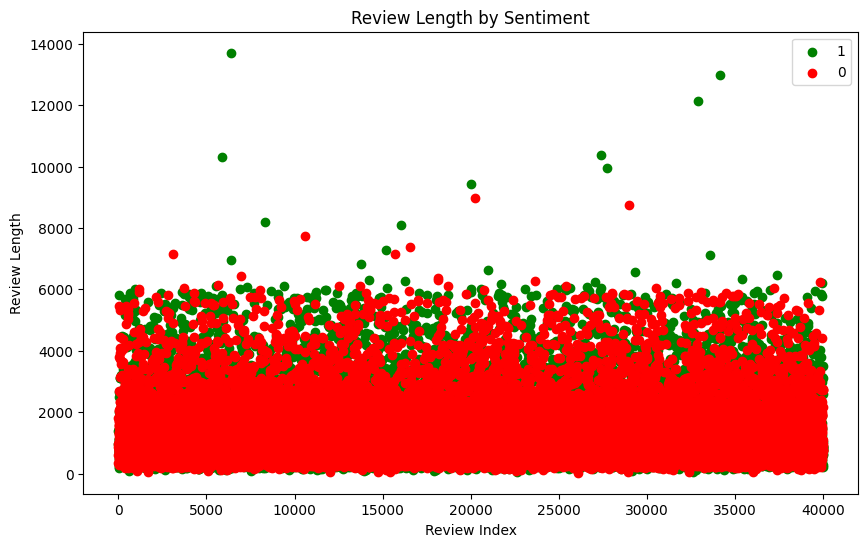

In [9]:
print(df['label'].value_counts())

df['review_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))

# Plot positive reviews in green
plt.scatter(df[df['label'] == 1].index, 
            df[df['label'] == 1]['review_length'], 
            color='green', label= 1)

# Plot negative reviews in red
plt.scatter(df[df['label'] == 0].index, 
            df[df['label'] == 0]['review_length'], 
            color='red', label= 0)

plt.xlabel('Review Index')
plt.ylabel('Review Length')
plt.title('Review Length by Sentiment')
plt.legend()
plt.show()

Check for empty datasets

In [10]:
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("The dataset must contain 'text' and 'label' columns")

In [11]:
## Train Test split and taking smaller samples

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Take smaller samples
train_sample = train_df.sample(n=1000, random_state=42)
test_sample = test_df.sample(n=200, random_state=42)

Word Level Truncation for quick learning

In [13]:
def word_level_truncation(text, max_words):
    return ' '.join(text.split()[:max_words])

Applying trucation

In [14]:
max_words = 200
train_sample['text'] = train_sample['text'].apply(lambda x: word_level_truncation(x, max_words))
test_sample['text'] = test_sample['text'].apply(lambda x: word_level_truncation(x, max_words))

## Using Hugging Face 

Convert DataFrames to Hugging Face Datasets

In [15]:
train_dataset = Dataset.from_pandas(train_sample)
test_dataset = Dataset.from_pandas(test_sample)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

Load the tokenizer and model

In [16]:
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Tokenize the data

In [17]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Data collector

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Train

Define the training arguments

In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
)

Define the metric for evaluation

In [21]:
def compute_metrics(p):
    logits, labels = p
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    accuracy_metric = load_metric("accuracy")
    accuracy = accuracy_metric.compute(predictions=predictions, references=torch.tensor(labels))['accuracy']
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Fine tuned Model

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\vaibh\AppData\Local\Temp\ipykernel_29268\3054915559.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
c:\Users\vaibh\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.40870389342308044, 'eval_accuracy': 0.84, 'eval_precision': 0.8426966292134831, 'eval_recall': 0.8064516129032258, 'eval_f1': 0.8241758241758241, 'eval_runtime': 97.2958, 'eval_samples_per_second': 2.056, 'eval_steps_per_second': 0.134, 'epoch': 1.0}
{'train_runtime': 1243.7526, 'train_samples_per_second': 0.804, 'train_steps_per_second': 0.051, 'train_loss': 0.3268023596869575, 'epoch': 1.0}


TrainOutput(global_step=63, training_loss=0.3268023596869575, metrics={'train_runtime': 1243.7526, 'train_samples_per_second': 0.804, 'train_steps_per_second': 0.051, 'total_flos': 132467398656000.0, 'train_loss': 0.3268023596869575, 'epoch': 1.0})

## Evaluate the model

In [23]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

  0%|          | 0/13 [00:00<?, ?it/s]

c:\Users\vaibh\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Evaluation results: {'eval_loss': 0.40870389342308044, 'eval_accuracy': 0.84, 'eval_precision': 0.8426966292134831, 'eval_recall': 0.8064516129032258, 'eval_f1': 0.8241758241758241, 'eval_runtime': 86.3218, 'eval_samples_per_second': 2.317, 'eval_steps_per_second': 0.151, 'epoch': 1.0}


#### Resources Used
https://youtu.be/jan07gloaRg?si=T9iDdNpNvBSb0k4g<br>
https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english/tree/main